### Load pre-processed text data and run LDA analysis for the desired number of topics

In [2]:
import pandas as pd

nyt_df = pd.read_json("../data/nyt_final.json")
nyt_df['date'] = pd.to_datetime(nyt_df['date'])
data_words = nyt_df.stemmed.values.tolist()
nyt_df.head()

,level_0,index,abstract,web_url,snippet,lead_paragraph,print_section,print_page,source,multimedia,...,author,keywords,date,day_of_week,weekend,year,keywords_join,all_text,processed,stemmed
1,1,1,The Costa Rican government said the crash occu...,https://www.nytimes.com/2017/12/31/world/ameri...,The Costa Rican government said the crash occu...,In the weeks before their family trip to Costa...,A,6,The New York Times,"[{'rank': 0, 'subtype': 'xlarge', 'caption': N...",...,Matthew Haag,"[Aviation Accidents, Safety and Disasters, Cos...",2018-01-01,0,0,2018,"Aviation Accidents, Safety and Disasters Costa...",The Costa Rican government said the crash occu...,"[costa, rican, government, said, crash, occurr...","[costa, rican, govern, crash, occur, mountain,..."
2,2,2,Families have turned the side of a warehouse f...,https://www.nytimes.com/2017/12/31/nyregion/me...,Families have turned the side of a warehouse f...,Maria stood outside the Metropolitan Detention...,A,1,The New York Times,"[{'rank': 0, 'subtype': 'xlarge', 'caption': N...",...,Annie Correal,"[Metropolitan Detention Center (Brooklyn, NY),...",2018-01-01,0,0,2018,"Metropolitan Detention Center (Brooklyn, NY) P...",Families have turned the side of a warehouse f...,"[family, turned, side, warehouse, facing, fede...","[famili, turn, side, warehous, face, feder, ja..."
3,3,3,Making New Year resolutions as a hedge against...,https://www.nytimes.com/2017/12/31/opinion/new...,Making New Year resolutions as a hedge against...,NASHVILLE — Two weeks ago I was reading a book...,A,19,The New York Times,"[{'rank': 0, 'subtype': 'jumbo', 'caption': No...",...,Margaret Renkl,"[Books and Literature, New Year, Dying: A Memo...",2018-01-01,0,0,2018,Books and Literature New Year Dying: A Memoir ...,Making New Year resolutions as a hedge against...,"[making, new, year, resolution, hedge, apocaly...","[new, resolut, hedg, apocalyps, new, resolut, ..."
5,5,5,Egypt’s ambassador asserts that the country is...,https://www.nytimes.com/2017/12/31/opinion/us-...,Egypt’s ambassador asserts that the country is...,To the Editor:,A,18,The New York Times,"[{'rank': 0, 'subtype': 'xlarge', 'caption': N...",...,,"[Egypt, United States International Relations]",2018-01-01,0,0,2018,Egypt United States International Relations,Egypt’s ambassador asserts that the country is...,"[egypt, ambassador, asserts, country, importan...","[egypt, ambassador, assert, countri, import, a..."
6,6,6,"Readers point to Congress, the Federal Railroa...",https://www.nytimes.com/2017/12/31/opinion/amt...,"Readers point to Congress, the Federal Railroa...",To the Editor:,A,18,The New York Times,"[{'rank': 0, 'subtype': 'xlarge', 'caption': N...",...,,"[Railroads, Transportation, Accidents and Safe...",2018-01-01,0,0,2018,Railroads Transportation Accidents and Safety ...,"Readers point to Congress, the Federal Railroa...","[reader, point, congress, federal, railroad, a...","[reader, point, congress, feder, railroad, adm..."


In [3]:
import gensim.corpora as corpora

# create dictionary, corpus and term document frequency
id2word = corpora.Dictionary(data_words)
texts = data_words 
corpus = [id2word.doc2bow(text) for text in texts]
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1), (6, 2), (7, 4), (8, 1), (9, 2), (10, 2), (11, 1), (12, 1), (13, 2), (14, 1), (15, 1), (16, 2), (17, 1), (18, 2), (19, 2), (20, 1), (21, 2), (22, 2), (23, 2), (24, 2), (25, 2), (26, 2), (27, 1), (28, 2), (29, 1)]


In [4]:
# check if corpus is iterable - if so i can use tqdm for a progress bar when training the lda model with this code:

#from tqdm._tqdm_notebook import tqdm_notebook
#tqdm_notebook.pandas(desc="Example Desc")   tqdm_notebook(corpus)

from collections.abc import Iterable
isinstance(corpus, Iterable)

True

In [6]:
# callbacks
from gensim.test.utils import get_tmpfile
from gensim.models.callbacks import CallbackAny2Vec

class EpochLogger(CallbackAny2Vec):

    def __init__(self):

        self.epoch = 0


    def on_epoch_begin(self, model):

        print("Epoch #{} start".format(self.epoch))


    def on_epoch_end(self, model):

        print("Epoch #{} end".format(self.epoch))

        self.epoch += 1

In [21]:
# alpha: how many topics each documents is generated from, beta: how many topics each word should be in
from pprint import pprint
import gensim
import tqdm
from gensim.models.callbacks import PerplexityMetric
from gensim.models.ldamodel import LdaModel # or gensim.models.LdaMulticore for callbacks 
import gensim.models.callbacks

num_topics = 120

perplexity_logger = PerplexityMetric(corpus=corpus)
#epoch_logger = gensim.models.callbacks.CoherenceMetric(corpus=corpus, coherence="u_mass", logger='shell')

# Build LDA model
def build_model(corpus,id2word,num_topics):
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics, # the number of topics in entire corpus
                                       passes= 1500,
                                       alpha = 0.2,
                                       eta = 0.5
                                          ) #callbacks=[perplexity_logger]  ) 
                                       #alpha = 1) 
    return lda_model

# Print the Keyword in the 10 topics
lda_model = build_model(corpus,id2word,num_topics)
#pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [22]:
lda_model.show_topics(num_words=20)

[(109,
  '0.063*"franc" + 0.047*"pari" + 0.040*"french" + 0.037*"street" + 0.032*"king" + 0.028*"wall" + 0.021*"martin" + 0.015*"jean" + 0.012*"emmanuel" + 0.012*"macron" + 0.010*"ross" + 0.010*"standard" + 0.009*"bet" + 0.009*"censu" + 0.008*"sweden" + 0.007*"howard" + 0.006*"switzerland" + 0.005*"swedish" + 0.005*"pen" + 0.005*"luther"'),
 (85,
  '0.140*"woman" + 0.045*"sexual" + 0.044*"girl" + 0.030*"victim" + 0.026*"harass" + 0.025*"sex" + 0.024*"sexism" + 0.023*"abus" + 0.017*"men" + 0.017*"femin" + 0.017*"blame" + 0.016*"accus" + 0.015*"male" + 0.015*"patriarchi" + 0.013*"survivor" + 0.012*"movement" + 0.012*"crime" + 0.012*"femal" + 0.012*"#metoo" + 0.011*"gaze"'),
 (13,
  '0.091*"black" + 0.043*"protest" + 0.028*"race" + 0.022*"georg" + 0.021*"social" + 0.020*"demonstr" + 0.019*"discrimin" + 0.018*"polic" + 0.018*"movement" + 0.018*"justic" + 0.016*"ethnic" + 0.015*"sjw" + 0.014*"american" + 0.013*"riot" + 0.012*"floyd" + 0.011*"anti" + 0.010*"violenc" + 0.009*"matter" + 0.008*

In [16]:
print('\Perplexity: ', lda_model.log_perplexity(corpus,
                                                total_docs=len(nyt_df))) 

\Perplexity:  -8.568257710438184


In [17]:
# calculate coherence
from gensim.models.coherencemodel import CoherenceModel

def get_coherence(lda_model, corpus, id2word):
    coherence_model_lda = CoherenceModel(model=lda_model,
                                     corpus=corpus, dictionary=id2word ,
                                     coherence='u_mass')
    return coherence_model_lda

coherence_model_lda = get_coherence(lda_model, corpus, id2word)
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence: ', coherence_lda)

Coherence:  -10.477186936749264


## Analyse how many topics makes the best model by calculated coherence 
Coherence in this case measures a single topic by the degree of semantic similarity between high scoring words in the topic (do these words co-occur across the text corpus). Whereas perplexity measures how probable some new unseen data is given the model that was learned earlier: how well does the model represent or reproduce the statistics of the original data. (https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0)

In [ ]:
coherence_scores = []

for i in range(3,27):
    num_topics = i
    lda_model = build_model(corpus,id2word,num_topics)
    coherence_model_lda = get_coherence(lda_model, corpus, id2word)
    coherence_scores.append(coherence_model_lda.get_coherence())

In [ ]:
import matplotlib.pyplot as plt

plt.plot(coherence_scores)
plt.show()

## Analyse the best values for alpha and beta
Alpha encondes our prior belief about the per document topic distribution. High alpha values lead to a more uniform distribution of topics across documents while low values lead to a sparse distribution where each document is assigned to a low number of topics. Beta encodes the per topic word distribution. Lower values of beta mean that each topic is associated with a small number of words.

In [ ]:
from tqdm import tqdm

def build_model(corpus,id2word,num_topics, a, b):
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics, # the number of topics in entire corpus
                                       passes= 5,
                                       workers=3,
                                       alpha = a,
                                       eta = b
                                          ) 
    return lda_model

# Print the Keyword in the 10 topics
a_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,2.0,3.0,4.0,5.0]
b_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,2.0,3.0,4.0,5.0]
coherence_scores = []

for a in tqdm(a_list):
    coh = []
    for b in b_list:
        lda_model = build_model(corpus,id2word,10, a, b)
        coherence_model_lda = get_coherence(lda_model, corpus, id2word)
        coh.append(coherence_model_lda.get_coherence())
    coherence_scores.append(coh)

coherence_scores

<Figure size 1000x1000 with 0 Axes>

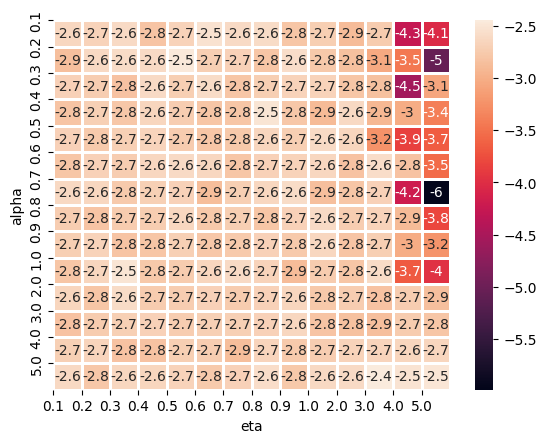

In [209]:
import seaborn as sns

plt.figure(figsize=(10,10))
fig, ax = plt.subplots()
heat_map = sns.heatmap( coherence_scores, linewidth = 1 , annot = True)
ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13], list(reversed(b_list))); plt.xlabel('eta')
ax.set_yticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13], a_list); plt.ylabel('alpha')
plt.show()

## Save model

In [23]:
from gensim.test.utils import datapath

# Save model to disk.
#temp_file = datapath('./results/lda_model15_')
lda_model.save('./results/lda/lda_model_120_1500') # 100 topics 1000 passes

## Load model

In [4]:
# Load a pretrained model from disk
from gensim.models.ldamodel import LdaModel

lda_model = LdaModel.load('./results/lda/lda_model_120_1500')# = LdaModel.load(temp_file)

# load lda column for 100-topic model, all_text_stemmed column for 150-topic model
#nyt_df = pd.read_json('../data/nyt_preprocessed_2018_100_1000.json')
#data_words = nyt_df.lda.values.tolist()

#import gensim.corpora as corpora

#id2word = corpora.Dictionary(data_words)
#corpus = [id2word.doc2bow(text) for text in data_words]

## Display results

In [ ]:
%%capture --no-display

import pyLDAvis.gensim_models
import pickle 
import pyLDAvis
import os
# Visualize the topics
num_topics = 15
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)# load the pre-prepared pyLDAvis data from disk
        
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

## Save highest probability topic for each document

In [4]:
# example of topic probabilities predicted for one article
print(lda_model[corpus[1]])
print(data_words[1])

[(3, 0.017416969), (27, 0.014408093), (37, 0.027685616), (42, 0.044642936), (46, 0.2172405), (54, 0.022131504), (65, 0.014397552), (67, 0.07412116), (73, 0.19732161), (97, 0.031229068), (104, 0.027151253), (114, 0.052670673)]
['famili', 'turn', 'side', 'warehous', 'face', 'feder', 'jail', 'brooklyn', 'messag', 'board', 'imprison', 'rel', 'famili', 'turn', 'side', 'warehous', 'face', 'feder', 'jail', 'brooklyn', 'messag', 'board', 'imprison', 'rel', 'maria', 'stood', 'outsid', 'metropolitan', 'detent', 'center', 'sunset', 'park', 'brooklyn', 'recent', 'jail', 'loom', 'concret', 'bulwark', 'dozen', 'stori', 'high', 'line', 'narrow', 'window', 'behind', 'husband', 'metropolitan', 'detent', 'center', 'brooklyn', 'prison', 'prison', 'famili', 'famili', 'life', 'poster', 'brooklyn', 'nyc', 'vi', 'photo']


In [5]:
lda_model.print_topic(67,topn=15)

'0.085*"child" + 0.083*"famili" + 0.044*"reader" + 0.041*"young" + 0.039*"parent" + 0.023*"mother" + 0.021*"childhood" + 0.019*"teenag" + 0.018*"germani" + 0.018*"son" + 0.017*"father" + 0.016*"editor" + 0.014*"wife" + 0.014*"daughter" + 0.013*"husband"'

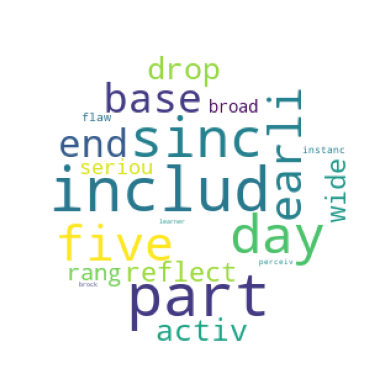

In [18]:
# or present the topics as wordclouds
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np

t = 81
plt.figure()
x, y = np.ogrid[:300, :300]
mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)
plt.imshow(WordCloud(max_font_size=50, max_words=20, background_color="white",mask=mask).fit_words(dict(lda_model.show_topic(t, 200))))
plt.axis("off")
#plt.savefig('1climate.png')
plt.show()

In [6]:
# save highest prob topic for each article into dataframe "article_topics"
from tqdm import tqdm

topics = []
probs = []
for i in tqdm(range(0,len(data_words))):
    topic_distribution = lda_model[corpus[i]]
    # find highest probability topic
    if len(topic_distribution) > 0:
        prob = topic_distribution[0][1]
        topic = topic_distribution[0][0]
        for j in range(0,len(topic_distribution)):
            if topic_distribution[j][1] > prob:
                prob = topic_distribution[j][1]
                topic = topic_distribution[j][0]
        # save highest probability topic
        topics.append(topic)
        probs.append(prob) 
    else:
        topics.append(500)
        probs.append(0)
        
zipped = list(zip(nyt_df['date'], topics, probs))
article_topics = pd.DataFrame(zipped, columns=['date', 'topic', 'probability'])
article_topics.head()

100%|████████████████████████████████████████████████████████████████████████| 263927/263927 [02:27<00:00, 1784.67it/s]


,date,topic,probability
0,2018-01-01,54,0.210143
1,2018-01-01,46,0.208756
2,2018-01-01,42,0.234854
3,2018-01-01,44,0.305829
4,2018-01-01,59,0.151013


In [28]:
# save article_topics df if desired
article_topics.to_csv('./results/lda/article_topics/nyt_article_topics_120_1500.csv')

## Check distribution of how topics were assigned

In [30]:
# print 10 most common topics and what percentage topic_counts_memesof the data they hold
topic_counts_nyt = pd.DataFrame(data={'topic': article_topics['topic'].value_counts().keys().to_list(), 'count': article_topics['topic'].value_counts().to_list()})

for i in range(0,10):
    topic = str(lda_model.print_topic(topic_counts_nyt.at[i,'topic']))
    percentage = str(round(topic_counts_nyt.at[i,'count']/len(article_topics)*100,1))
    print(percentage + '% of articles: ' + topic + '\n')

10.0% of articles: 0.016*"time" + 0.014*"life" + 0.011*"way" + 0.011*"person" + 0.010*"mani" + 0.008*"work" + 0.007*"type" + 0.007*"content" + 0.007*"thing" + 0.006*"find"

6.6% of articles: 0.096*"state" + 0.070*"unit" + 0.048*"govern" + 0.040*"polit" + 0.040*"presid" + 0.034*"trump" + 0.022*"nation" + 0.017*"american" + 0.015*"washington" + 0.014*"biden"

6.5% of articles: 0.084*"coronaviru" + 0.072*"pandem" + 0.053*"covid" + 0.049*"viru" + 0.041*"toilet" + 0.041*"tissu" + 0.041*"towel" + 0.041*"corona" + 0.041*"rona" + 0.038*"ncov"

6.3% of articles: 0.063*"elect" + 0.043*"parti" + 0.042*"democrat" + 0.032*"republican" + 0.031*"polit" + 0.027*"senat" + 0.025*"presidenti" + 0.021*"vote" + 0.019*"state" + 0.015*"trump"

4.2% of articles: 0.065*"movi" + 0.031*"film" + 0.020*"seri" + 0.016*"star" + 0.014*"documentari" + 0.014*"televis" + 0.013*"actor" + 0.013*"program" + 0.012*"australia" + 0.012*"tenni"

4.1% of articles: 0.034*"game" + 0.018*"sport" + 0.016*"team" + 0.016*"leagu" + 0.

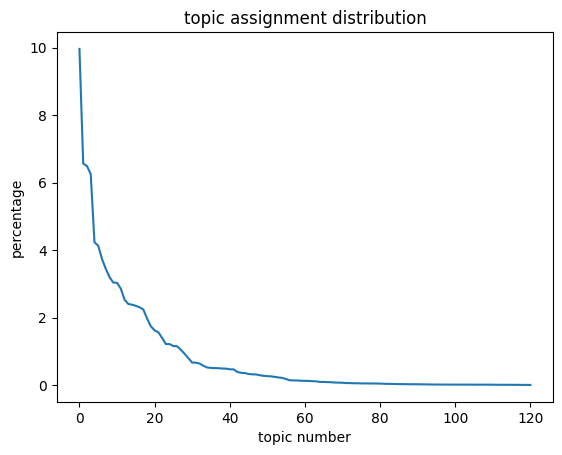

In [33]:
import matplotlib.pyplot as plt

topic_counts_nyt['percentage'] = (topic_counts_nyt['count']/len(article_topics))*100
topic_counts_nyt['percentage'].plot()
plt.title('topic assignment distribution')
plt.ylabel('percentage')
plt.xlabel('topic number')
plt.show()